In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer, confusion_matrix
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.classified_regression import ClassifiedRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [ ]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [ ]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Gargage collection
del trn
del trn_comb
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

In [ ]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

In [ ]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
# Garbage collection
del trn_withRef_comb
print X.shape, y.shape

In [ ]:
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
def LogPlusOne_score(ground_truth, predictions):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

In [ ]:
reg_sub = [None, None]
for i in [0, 1]:
    base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7))], copy = False)
    base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=7))], copy = False)
    base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
    base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
    base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
    base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
    base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
    base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
    blender = Ridge(alpha=1.45)
    base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
    reg_sub[i] = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.15, with_feature=True)
reg_sub = tuple(reg_sub)
clf = xgb.sklearn.XGBClassifier(n_estimators=500, nthread=14)
reg = ClassifiedRegressor(labeling_thresh=np.log10(1+45) , classifier=clf, proba_thresh=0.05, regressors=reg_sub, verbose=1)
pip = Pipeline([('lpo',lpo), ('imp',imp), ('ss',ss), ('reg',reg)], copy=True)  # a Pipeline wrapper to chain'em up

# CV

In [ ]:
# label at 45, class xgb 500, proba_thresh=0
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)

In [ ]:
# label at 45, class xgb 500, proba_thresh=0.05
clf = xgb.sklearn.XGBClassifier(n_estimators=500, nthread=14)
reg = ClassifiedRegressor(labeling_thresh=np.log10(1+45) , classifier=clf, proba_thresh=0.25, regressors=reg_sub, verbose=1)
pip = Pipeline([('lpo',lpo), ('imp',imp), ('ss',ss), ('reg',reg)], copy=True)  # a Pipeline wrapper to chain'em up
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)

# Random tests

In [8]:
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.1, random_state=123)

In [10]:
clf = xgb.sklearn.XGBClassifier(n_estimators=500, nthread=7)
reg = ClassifiedRegressor(labeling_thresh=np.log10(1+45) , classifier=clf, proba_thresh=0, regressors=reg_sub, verbose=1)
pip = Pipeline([('lpo',lpo), ('imp',imp), ('ss',ss), ('reg',reg)], copy=True)  # a Pipeline wrapper to chain'em up

In [10]:
t = time.time()
pip.fit(X_trn, y_trn)
print time.time()-t

658400 640205 18195  
1544.30856919


## test=0.1, random_state=123

In [11]:
pip_sub = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', pip.steps[3][1].classifier)], copy=True)
y_label_val_predict_prob = pip_sub.predict_proba(X_val)[:, 0]
score = []
param_range = np.arange(0, 1.1, 0.1)
for i, th in enumerate(param_range):
    c = confusion_matrix(y_val>45, y_label_val_predict_prob<th)
    pip.steps[3][1].proba_thresh = th    
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip.predict(X_val)))

73156 73156 0  
=====th = 0.0=====(TP 0, FN 1960, TN 71196, FP 0)===score 21.1543183973
73156 73156 0  
=====th = 0.1=====(TP 0, FN 1960, TN 71196, FP 0)===score 21.1543183973
73156 73155 1  
=====th = 0.2=====(TP 1, FN 1959, TN 71196, FP 0)===score 21.1533034629
73156 73144 12  
=====th = 0.3=====(TP 12, FN 1948, TN 71196, FP 0)===score 21.035716272
73156 73126 30  
=====th = 0.4=====(TP 26, FN 1934, TN 71192, FP 4)===score 20.866935504
73156 73095 61  
=====th = 0.5=====(TP 49, FN 1911, TN 71184, FP 12)===score 20.6126231245
73156 73052 104  
=====th = 0.6=====(TP 79, FN 1881, TN 71171, FP 25)===score 20.4301522881
73156 72970 186  
=====th = 0.7=====(TP 118, FN 1842, TN 71128, FP 68)===score 20.6095284774
73156 72750 406  
=====th = 0.8=====(TP 183, FN 1777, TN 70973, FP 223)===score 20.9785360079
73156 71195 1961  
=====th = 0.9=====(TP 430, FN 1530, TN 69665, FP 1531)===score 27.3770896858
73156 0 73156  
=====th = 1.0=====(TP 1960, FN 0, TN 0, FP 71196)===score 240.734248563


In [ ]:
pip_sub = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', pip.steps[3][1].classifier)], copy=True)
score = []
param_range = np.arange(0, 1.1, 0.1)
for i, th in enumerate(param_range):
    pip.steps[3][1].proba_thresh = th 
    pip.fit(X_trn, y_trn)
    y_label_val_predict_prob = pip_sub.predict_proba(X_val)[:, 0]
    c = confusion_matrix(y_val>45, y_label_val_predict_prob<th)
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip.predict(X_val)))

Training classifier, total samples = {}... label False subtotal 640205... label True subtotal 18195... fitting regressors, total samples = 658400... regressor 0 fits label False subtotal 640205... regressor 1 fits label True subtotal 18195...  
Regressor prediction, total samples = 73156... regressor 0 predicts label False subtotal 73156... regressor 1 predicts label True subtotal 0...  
=====th = 0.0=====(TP 0, FN 1960, TN 71196, FP 0)===score 21.1579417502
Training classifier, total samples = {}... label False subtotal 640205... label True subtotal 18195... regressor 1 fits label True subtotal 18195...  
Regressor prediction, total samples = 73156... regressor 0 predicts label False subtotal 73156... regressor 1 predicts label True subtotal 0...  
=====th = 0.1=====(TP 0, FN 1960, TN 71196, FP 0)===score 21.1583132542
Training classifier, total samples = {}... label False subtotal 640205... label True subtotal 18195... fitting regressors, total samples = 658400... regressor 0 fits la

## test=0.2, random_state=12345

146312 146185 127  
22.410913293


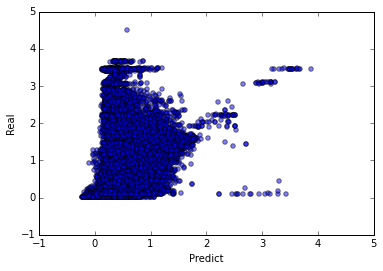

In [19]:
# ==============================
pip.steps[3][1].proba_thresh = 0.5
y_val_lpo_predict = pip.predict(X_val)
plt.scatter(y_val_lpo_predict, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict)

146312 146312 0  
22.7154519485


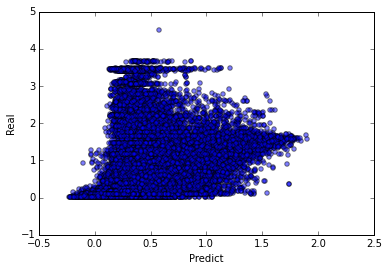

In [20]:
# ==============================
pip.steps[3][1].proba_thresh = 0
y_val_lpo_predict = pip.predict(X_val)
plt.scatter(y_val_lpo_predict, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict)

In [21]:
pip_sub = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', pip.steps[3][1].classifier)], copy=True)
y_label_val_predict_prob = pip_sub.predict_proba(X_val)[:, 0]
score = []
param_range = np.arange(0, 1.1, 0.1)
for i, th in enumerate(param_range):
    c = confusion_matrix(y_val>45, y_label_val_predict_prob<th)
    pip.steps[3][1].proba_thresh = th    
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip.predict(X_val)))

146312 146312 0  
=====th = 0.0=====(TP 0, FN 4078, TN 142234, FP 0)===score 22.7154519485
146312 146311 1  
=====th = 0.1=====(TP 1, FN 4077, TN 142234, FP 0)===score 22.7148858015
146312 146308 4  
=====th = 0.2=====(TP 4, FN 4074, TN 142234, FP 0)===score 22.7078915026
146312 146291 21  
=====th = 0.3=====(TP 20, FN 4058, TN 142233, FP 1)===score 22.68618532
146312 146249 63  
=====th = 0.4=====(TP 59, FN 4019, TN 142230, FP 4)===score 22.5545952872
146312 146185 127  
=====th = 0.5=====(TP 104, FN 3974, TN 142211, FP 23)===score 22.410913293
146312 146086 226  
=====th = 0.6=====(TP 172, FN 3906, TN 142180, FP 54)===score 22.1148573686
146312 145929 383  
=====th = 0.7=====(TP 240, FN 3838, TN 142091, FP 143)===score 22.2547612925
146312 145467 845  
=====th = 0.8=====(TP 384, FN 3694, TN 141773, FP 461)===score 22.5940246644
146312 142708 3604  
=====th = 0.9=====(TP 885, FN 3193, TN 139515, FP 2719)===score 28.690237183
146312 0 146312  
=====th = 1.0=====(TP 4078, FN 0, TN 0, FP

## test=0.2, random_state=123

In [13]:
pip_sub = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', pip.steps[3][1].classifier)], copy=True)
y_label_val_predict_prob = pip_sub.predict_proba(X_val)[:, 0]
score = []
param_range = np.arange(0, 1.1, 0.1)
for i, th in enumerate(param_range):
    c = confusion_matrix(y_val>45, y_label_val_predict_prob<th)
    pip.steps[3][1].proba_thresh = th    
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip.predict(X_val)))

146312 146312 0  
=====th = 0.0=====(TP 0, FN 3946, TN 142366, FP 0)===score 21.6521295569
146312 146311 1  
=====th = 0.1=====(TP 1, FN 3945, TN 142366, FP 0)===score 21.6511534091
146312 146307 5  
=====th = 0.2=====(TP 5, FN 3941, TN 142366, FP 0)===score 21.6517804973
146312 146291 21  
=====th = 0.3=====(TP 20, FN 3926, TN 142365, FP 1)===score 21.576269144
146312 146250 62  
=====th = 0.4=====(TP 54, FN 3892, TN 142358, FP 8)===score 21.4164383164
146312 146187 125  
=====th = 0.5=====(TP 101, FN 3845, TN 142342, FP 24)===score 21.1995667345
146312 146086 226  
=====th = 0.6=====(TP 164, FN 3782, TN 142304, FP 62)===score 21.0412319948
146312 145915 397  
=====th = 0.7=====(TP 242, FN 3704, TN 142211, FP 155)===score 21.1336896047
146312 145459 853  
=====th = 0.8=====(TP 387, FN 3559, TN 141900, FP 466)===score 21.7799036403
146312 142516 3796  
=====th = 0.9=====(TP 876, FN 3070, TN 139446, FP 2920)===score 27.7472724682
146312 0 146312  
=====th = 1.0=====(TP 3946, FN 0, TN 0,

# Submission Generation

In [9]:
pip.fit(X, y)

731556 711401 20155  


Pipeline(copy=True,
     steps=[('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('reg', ClassifiedRegressor(classifier=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,...solver='auto', tol=0.001),
         blending_split=0.15, with_feature=True)),
          verbose=1))])

In [10]:
test = pd.read_csv('../data/test.csv')
test_comb = test.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_comb.columns.values)]
test_withRef_comb = test_comb[pd.notnull(test_comb.Ref_mean)]
# Add deterministic estimator as columns
# MP params=0.82
test_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, test_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
test_withRef_comb.loc[:,'KDP'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
test_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
test_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,test_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    test_withRef_comb.loc[test_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])
test_X = test_withRef_comb.ix[:, [col for col in test_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
print test_X.shape
test_y_predict = 10**pip.predict(X=test_X)-1

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(426094, 136)
426094 425673 421  


In [11]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151203_192950.csv
